# Notebook with working models in NumPyro

--------

In [1]:
# Load necessary packages
import numpyro
import numpyro.distributions as dist

import jax
import jax.numpy as jnp

from helper import custom_put_along_axis

In [214]:
# Minimal example
reference = jnp.array([0])
reads = jnp.array([[0], [1], [1], [1], [0], [1], [0], [1]])
alphabet ='01'

cluster_num = 5

input_data = reference, reads, len(alphabet), cluster_num

----

## Model - Finite DPM

#### Finite Dirichlet mixture model with fixed number of clusters. 

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)  
alphabet = {A, C, G, T, -}


no-mutation rate: $\gamma \sim Beta(a,b)$   
no-error rate: $\theta \sim Beta(c,d)$   
Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$  
Cluster assignments ($N$-dim): $z|\pi \sim Categorical(\pi)$  
Cluster centers/haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=
\begin{cases} 
\gamma,  \text{ if }i = ref[l] \\
\frac{1-\gamma}{4}, \text{ else. }
\end{cases}$ for $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  
Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=
\begin{cases} 
\theta,  \text{ if }i = h_{z_n}[l] \\
\frac{1-\theta}{4}, \text{ else. }
\end{cases}$ for $n \in {1, ..., N}$, $l \in {1, ..., L}$ and $i\in {1,..., |alphabet|}$  



In [215]:
def model_finiteDPM(input_data):
    reference, read_data, alphabet_length, cluster_num = input_data

    # parameters
    read_count = read_data.shape[0]
    genome_length = read_data.shape[1]
    alphabet_length = alphabet_length

    # define rates
    mutation_rate = numpyro.sample('mutation_rate', dist.Beta(1, 1))
    error_rate = numpyro.sample('error_rate', dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1)
    )
    mutation_rate_matrix = custom_put_along_axis(
        mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1
    )

    alpha0 = 0.001 # alpha must be bigger than zero
    alpha = alpha0 * jnp.ones(cluster_num) / cluster_num
    cluster_weights = numpyro.sample("cluster_weights", dist.Dirichlet(jnp.ones(cluster_num)))

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", cluster_num, dim=-2):
        
        with genome_axis:
            haplotypes = numpyro.sample("haplotypes", dist.Categorical(mutation_rate_matrix))  # cluster centers

    with numpyro.plate("read_axis", read_count, dim=-2):
        cluster_assignments = numpyro.sample("cluster_assignments", dist.Categorical(cluster_weights))
        
        with genome_axis:
            
            error_rate_matrix = jnp.full(
                (read_count, genome_length, alphabet_length), (1 - error_rate) / (alphabet_length - 1)
            )
            error_rate_matrix = custom_put_along_axis(
                error_rate_matrix, haplotypes[cluster_assignments].reshape(read_count, genome_length, 1), error_rate, axis=2
            )

            obs=numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

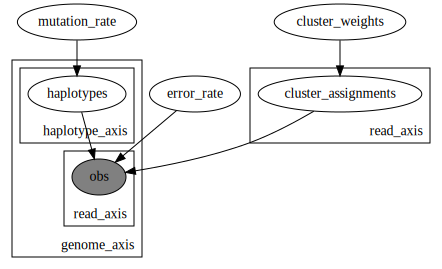

In [216]:
numpyro.render_model(model_finiteDPM, model_args=(input_data,))

-----

## Model - Infinite DPM - Stickbreaking process
#### Dirichlet mixture model where number of clusters is learn.

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)  
alphabet = {A, C, G, T, -}


no-mutation rate: $\gamma \sim Beta(a,b)$   
no-error rate: $\theta \sim Beta(c,d)$  

In [221]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    return jnp.pad(beta, (0, 1), constant_values=1) * jnp.pad(
        beta1m_cumprod, (1, 0), constant_values=1
    )


def model_infiniteSBP(input_data):
    reference, read_data, alphabet_length, max_cluster_num_guess = input_data

    max_cluster_num_guess = 10  # guess for maximum number of clusters

    # parameters
    read_count = read_data.shape[0]
    genome_length = reference.shape[0]
    alphabet_length = alphabet_length #jnp.unique(reference).shape[0]

    # define rates
    mutation_rate = numpyro.sample("mutation_rate", dist.Beta(1, 1))
    error_rate = numpyro.sample("error_rate", dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1)
    )
    mutation_rate_matrix = custom_put_along_axis(
        mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1
    )

    with numpyro.plate("beta_plate", max_cluster_num_guess - 1):
        beta = numpyro.sample("beta", dist.Beta(1, 1.1))
    
    cluster_weights = numpyro.sample(
        "cluster_weights", dist.Dirichlet(mix_weights(beta))
    )

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", max_cluster_num_guess, dim=-2):
        with genome_axis:
            haplotypes = numpyro.sample(
                "haplotypes", dist.Categorical(mutation_rate_matrix)
            )  # cluster centers

    with numpyro.plate("read_axis", read_count, dim=-2):
        cluster_assignments = numpyro.sample(
            "cluster_assignments", dist.Categorical(cluster_weights)
        )

        with genome_axis:
            error_rate_matrix = jnp.full(
                (read_count, genome_length, alphabet_length),
                (1 - error_rate) / (alphabet_length - 1),
            )
            error_rate_matrix = custom_put_along_axis(
                error_rate_matrix,
                haplotypes[cluster_assignments].reshape(read_count, genome_length, 1),
                error_rate,
                axis=2,
            )

            numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

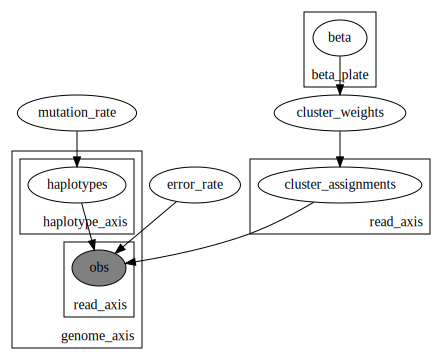

In [222]:
numpyro.render_model(model_infiniteSBP, model_args=(input_data,))

----

## Model - Finite DPM

#### Finite Dirichlet mixture model with fixed number of clusters. With extension of error and mutation model accounting for number of matches, number of subsitutions, number of deletions

ref = reference sequence  
$N$ = number of reads  
$K$ = number of clusters/components  
$L$ = genome length (number of positions)  
alphabet = {A, C, G, T, -}


mutation rate: $\gamma, \gamma_S, \gamma_{D^f} \gamma_{D^b}\sim Dirichlet(a,b,c,d)$  

mutation rate matrix depending on the reference:
$
\begin{matrix}
ref & A & C & G & T & - \\
A & \gamma & \gamma_S & \gamma_S & \gamma_S & \gamma_{D^b} \\
C & \gamma_S & \gamma & \gamma_S & \gamma_S & \gamma_{D^b} \\
G & \gamma_S & \gamma_S & \gamma & \gamma_S & \gamma_{D^b} \\
T & \gamma_S & \gamma_S & \gamma_S & \gamma & \gamma_{D^b} \\
- & \gamma_{D^f} & \gamma_{D^f}& \gamma_{D^f} & \gamma_{D^f} & \gamma \\
\end{matrix}
$

error rate: $\theta, \theta_S, \theta_{D^f} \theta_{D^b} \sim Dirichlet(a,b,c,d)$   

error rate matrix depending on the assigned haplotype:
$
\begin{matrix}
haplotype & A & C & G & T & - \\
A & \theta & \theta_S & \theta_S & \theta_S & \theta_{D^b} \\
C & \theta_S & \theta & \theta_S & \theta_S & \theta_{D^b} \\
G & \theta_S & \theta_S & \theta & \theta_S & \theta_{D^b} \\
T & \theta_S & \theta_S & \theta_S & \theta & \theta_{D^b} \\
- & \theta_{D^f} & \theta_{D^f}& \theta_{D^f} & \theta_{D^f} & \theta \\
\end{matrix}
$


Cluster weights ($K$-dim): $\pi | \alpha \sim Dir(\alpha)$ 

Cluster assignments ($N$-dim): $z|\pi \sim Categorical(\pi)$  

Cluster centers/haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(W) $ 
with $W(l,i)=$ mutation rates (see above).

Likelihood of the reads ($N$-dim): $r | z, h, \theta \sim Categorical(E)$ 
with $E(n,l,i)=$  error rate matrix (see above).



In [223]:
def model_finiteDPM_extended(input_data):
    '''
    This model is only for alphabet={A,C,G,T,-} as deletion mutations and errors are treated seperatly 
    (wrt to subsitutions).
    '''
    cluster_num = 10
    reference, read_data, alphabet_length = input_data

    # parameters
    read_count = read_data.shape[0]
    genome_length = read_data.shape[1]
    alphabet_length = alphabet_length

    # define rates
    mutation_rate = numpyro.sample('mutation_rate', dist.Dirichlet(jnp.ones(4)/4))
    error_rate = numpyro.sample('error_rate', dist.Dirichlet(jnp.ones(4)/4))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), mutation_rate[1] / (alphabet_length - 2)
    ) # subsitutions
    mutation_rate_matrix = mutation_rate_matrix.at[:,4].set(mutation_rate[2]) # deletion in haplotype
    
    '''
    # TODO: 
    # Option 0: 
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,:].set(mutation_rate[3] / (alphabet_length - 1))
    # Option 1: 
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,:].set((mutation_rate[3] / (alphabet_length - 1))*jnp.ones(5))
    # Option 2: 
    indicies = jnp.argwhere(reference==4)
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,0].set(
        mutation_rate[3] / (alphabet_length - 1)
    )
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,1].set(
        mutation_rate[3] / (alphabet_length - 1)
    )
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,2].set(
        mutation_rate[3] / (alphabet_length - 1)
    )
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,3].set(
        mutation_rate[3] / (alphabet_length - 1)
    )
    mutation_rate_matrix = mutation_rate_matrix.at[indicies,4].set(
        mutation_rate[0]
    )
    '''
    mutation_rate_matrix = custom_put_along_axis(
        mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate[0], axis=1
    ) # matches
    mutation_rate_matrix = mutation_rate_matrix / mutation_rate_matrix.sum(axis=1)[:,jnp.newaxis] #normalize
    

    alpha0 = 0.001 # alpha must be bigger than zero
    alpha = alpha0 * jnp.ones(cluster_num) / cluster_num
    cluster_weights = numpyro.sample("cluster_weights", dist.Dirichlet(jnp.ones(cluster_num)))

    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", cluster_num, dim=-2):
        
        with genome_axis:
            haplotypes = numpyro.sample("haplotypes", dist.Categorical(mutation_rate_matrix))  # cluster centers
    
    with numpyro.plate("read_axis", read_count, dim=-2):
        cluster_assignments = numpyro.sample("cluster_assignments", dist.Categorical(cluster_weights))
        with genome_axis:
            error_rate_matrix = jnp.full(
                (read_count, genome_length, alphabet_length),
                error_rate[1] / (alphabet_length - 1),
            ) # substitutions 
            error_rate_matrix = error_rate_matrix.at[:,:,4].set(error_rate[2]) # deletion in read
            '''
            # TODO: Find solution to this problem!! It is doing the right thing but its messing up 
            # after one or two iterations
            # deletion in haplotype:
            # this are the indices where we want to have theta_Db
            ind_list = jnp.argwhere(haplotypes[cluster_assignments].reshape(read_count, genome_length)==4)
            for ind in ind_list:
                error_rate_matrix = error_rate_matrix.at[ind[0],ind[1]].set(error_rate[3]) # deletion in haplotype 
            '''
            error_rate_matrix = custom_put_along_axis(
                error_rate_matrix,
                haplotypes[cluster_assignments].reshape(read_count, genome_length, 1),
                error_rate[0],
                axis=2,
            ) # matches 

            numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

In [224]:
numpyro.render_model(model_finiteDPM_extended, model_args=(input_data,))

ValueError: too many values to unpack (expected 3)

## Model - Hierarchical Dirichlet Process Mixture (hierDPM)


$m \in \{1, ..., M\}$ samples denoted as $\{x_1, ..., x_M \}$ where sample $x_m = \{r_1, ..., r_{n_m}\}$  
Note that every sample can have a different amount of reads.  
$k \in \{1, ..., K\}$ mixtures/clusters

For now lets have $\gamma$ (mutation rate) and $\theta$ (error rate) fixed. 

$p(x_1, ... , x_M) = \prod _{m=1}^M p()$

where:

$z_{mn} \sim Categorical(\pi_m)$ and $\pi_m =(\pi_{m1}, ...,\pi_{mK})$

for each $m \in \{1, ..., M\}$: $\pi_m \sim Dirichlet(\alpha)$ with $\alpha$ being $K$-dimensional

haplotypes ($K$x$L$-dim): $h | ref, \gamma \sim Categorical(M)$ with $M$ mutation rate matrix (similar defined like above)




In [225]:
# Minimal example input

reference = jnp.array([0])
reads = jnp.array([[[0], [1], [1], [1], [0], [1], [0], [1]], [[0], [0], [0], [1], [0], [1], [0], [1]]])
alphabet ='01'

cluster_num = 5

input_data = reference, reads, len(alphabet), cluster_num

### TODO: How to solve the problem that different samples will have a different amount of reads?

In [226]:
def mix_weights(beta):
    beta1m_cumprod = (1 - beta).cumprod(-1)
    pad_beta = jnp.pad(beta, ((0, 0),(0, 1)), constant_values=1)
    pad_beta1m_cumprod = jnp.pad(beta1m_cumprod, ((0, 0),(1, 0)), constant_values=1)
    
    return pad_beta*pad_beta1m_cumprod

def shape_parameters(alpha, beta):
    # first shape parameter of beta distribution 
    first = alpha * beta
    
    # second shape parameter of beta distribution 
    beta_cumsum = beta.cumsum(-1) # K-1 dimensional 
    second = jnp.pad(beta_cumsum, (1, 0), constant_values=0)
    second = second[:-1]
    second = alpha * (1 - second)
    
    return [first, second]


def model_hierarchicalSBMM(input_data):
    reference, read_data, alphabet_length, max_cluster_num_guess = input_data

    # parameters
    samples_count = read_data.shape[0]
    read_count = read_data.shape[1]
    genome_length = reference.shape[0]
    alphabet_length = alphabet_length 
    
    # set hyperparameters
    gamma = 1.1
    alpha = 1.1
    
    # define rates
    mutation_rate = numpyro.sample("mutation_rate", dist.Beta(1, 1))
    error_rate = numpyro.sample("error_rate", dist.Beta(1, 1))

    # create matrix of rates
    mutation_rate_matrix = jnp.full(
        (genome_length, alphabet_length), (1 - mutation_rate) / (alphabet_length - 1)
    )
    mutation_rate_matrix = custom_put_along_axis(
        mutation_rate_matrix, reference.reshape(genome_length, 1), mutation_rate, axis=1
    )
    
    # top hierarchical level - base distribution for all samples
    beta_plate = numpyro.plate("beta_plate", max_cluster_num_guess - 1)
    with beta_plate:
        beta_top = numpyro.sample("beta_top", dist.Beta(1*jnp.ones(max_cluster_num_guess - 1), gamma*jnp.ones(max_cluster_num_guess - 1)))

    # sample level - draw weights for each sample
    sample_plate = numpyro.plate("sample_plate", samples_count, dim=-2)
    with sample_plate:
        param = shape_parameters(alpha, beta_top)
        beta = numpyro.sample("beta", dist.Beta(param[0],param[1]))
    
    cluster_weights = numpyro.sample(
    "cluster_weights", dist.Dirichlet(mix_weights(beta))
    ) # n_samples X num_cluster
        
    genome_axis = numpyro.plate("genome_axis", genome_length, dim=-1)
    with numpyro.plate("haplotype_axis", max_cluster_num_guess, dim=-2):
        with genome_axis:
            haplotypes = numpyro.sample(
                "haplotypes", dist.Categorical(mutation_rate_matrix)
            )  # cluster centers

    with numpyro.plate("sample_plate", samples_count, dim=-2):
        with numpyro.plate("read_axis", read_count, dim=-1):
            cluster_weights = jnp.repeat(cluster_weights[:,jnp.newaxis,:], read_count, axis=1)
            cluster_assignments = numpyro.sample(
                "cluster_assignments", dist.Categorical(cluster_weights)
            ) # n_samples x n_reads 
            
    with numpyro.plate("sample_plate", samples_count, dim=-3):    
        with numpyro.plate("read_axis", read_count, dim=-2):
            with genome_axis:
                error_rate_matrix = jnp.full(
                    (samples_count, read_count, genome_length, alphabet_length),
                    (1 - error_rate) / (alphabet_length - 1),
                )
                error_rate_matrix = custom_put_along_axis(
                    error_rate_matrix,
                    haplotypes[cluster_assignments].reshape(samples_count, read_count, genome_length, 1),
                    error_rate,
                    axis=3,
                )

                numpyro.sample("obs", dist.Categorical(error_rate_matrix), obs=read_data)

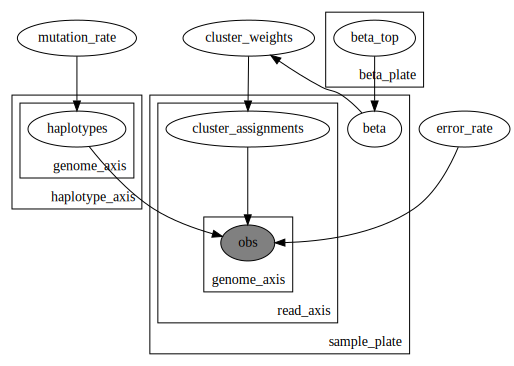

In [227]:
numpyro.render_model(model_hierarchicalSBMM, model_args=(input_data,))